In [1]:
import tools, evaluation, datasets, numpy

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled)


In [2]:
results = {'cosine' : {}, 'hierarchy' : {}}

for method, result_dict in results.items():
    result_dict['caps'] = []
    result_dict['ranks'] = []
    result_dict['c2c_errs'] = []
    
    for coco_split in range(5):
        dataset = datasets.load_dataset(name='coco', cnn='relu_oversample', captions='raw', load_train=False, coco_split=coco_split)
        m = tools.load_model('snapshots/coco_new_ablation_' + method + '_raw_relu_oversample.npz')
        from hierarchy_data import HierarchyData
        dev = HierarchyData(dataset['dev'], m['worddict'], n_words = len(m['worddict']))
        caps, ims = dev.all()
        I = tools.encode_images(m, ims)
        S = tools.encode_sentences(m, caps)
        import model
        import theano
        from model import build_errors
        inps, errs = build_errors(m['options'])
        m['f_err'] = theano.function(inps, errs)
        errs= tools.compute_errors(m, S, I)
        _, ranks = evaluation.t2i(errs)
        print(len(ranks))
        result_dict['caps'].append(caps)
        result_dict['ranks'].append(ranks)
        result_dict['c2c_errs'].append(tools.compute_errors(m,S,S))
    
    result_dict['caps'] = numpy.vstack(result_dict['caps'])
    result_dict['ranks'] = numpy.vstack(result_dict['ranks'])
    result_dict['c2c_errs'] = numpy.vstack(result_dict['c2c_errs'])
    
    

snapshots/coco_new_ablation_hierarchy_raw_relu_oversample.npz
Loading dictionary...
Creating inverted dictionary...
Loading model options...
Loading model parameters...
Compiling sentence encoder...

/u/vendrov/anaconda/lib/python2.7/site-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '18143' (I am process '18352')



Compiling image encoder...
Packing up...
5000
snapshots/coco_new_ablation_hierarchy_raw_relu_oversample.npz
Loading dictionary...
Creating inverted dictionary...
Loading model options...
Loading model parameters...
Compiling sentence encoder...
Compiling image encoder...
Packing up...
5000
snapshots/coco_new_ablation_hierarchy_raw_relu_oversample.npz
Loading dictionary...
Creating inverted dictionary...
Loading model options...
Loading model parameters...
Compiling sentence encoder...
Compiling image encoder...
Packing up...
5000
snapshots/coco_new_ablation_hierarchy_raw_relu_oversample.npz
Loading dictionary...
Creating inverted dictionary...
Loading model options...
Loading model parameters...
Compiling sentence encoder...
Compiling image encoder...
Packing up...
5000
snapshots/coco_new_ablation_hierarchy_raw_relu_oversample.npz
Loading dictionary...
Creating inverted dictionary...
Loading model options...
Loading model parameters...
Compiling sentence encoder...
Compiling image enc

In [3]:
results['hierarchy']['ranks'].shape

(5, 5000)

In [4]:
for key, result_dict in results.items():
    result_dict['caps'] = [c for cs in result_dict['caps'] for c in cs]
    result_dict['ranks'] = result_dict['ranks'].flatten()

In [5]:
caps = results['hierarchy']['caps']

In [6]:
len(caps)

25000

In [7]:
# new stuff
diffs = []
for i in range(5000):
    max_diff = 0
    for j in range(5):
        cap_j = 5*i + j
        for k in range(5):
            cap_k = 5*i + k
            max_diff = max(max_diff, abs(len(caps[cap_k].split()) - len(caps[cap_j].split())))
    for j in range(5):
        diffs.append(max_diff)

In [8]:
diffs = numpy.array(diffs)

In [16]:
results['cosine']['ranks'].min()

1.0

In [20]:
from collections import defaultdict
diff2indices = defaultdict(list)
for i in range(len(diffs)):
    diff2indices[diffs[i]].append(i)
    
for key, result_dict in results.items():
    diffs2mean = {}
    for (i, caps) in diff2indices.iteritems():
        diffs2mean[i] = result_dict['ranks'][caps].mean()
    result_dict['diffs2mean'] = diffs2mean

In [62]:
len2indices = defaultdict(list)
for (i, cap) in enumerate(results['hierarchy']['caps']):
    len2indices[len(cap.split())].append(i)
    
for key, result_dict in results.items():
    len2mean = {}
    for (i, caps) in len2indices.iteritems():
        len2mean[i] = result_dict['ranks'][caps].mean()
    result_dict['len2mean'] = len2mean

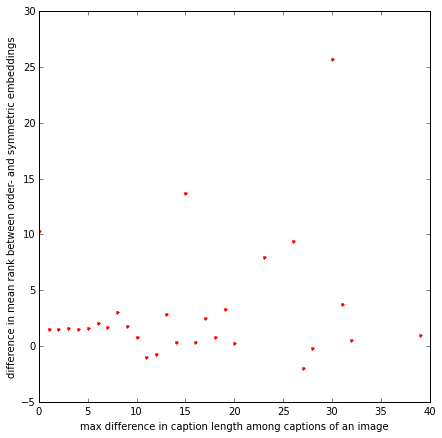

In [54]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(7,7))
#plt.title('Difference in mean rank between order- and symmetric embeddings for a given difference in caption length')

cos_ranks = numpy.array(results['cosine']['diffs2mean'].values())
h_ranks = numpy.array(results['hierarchy']['diffs2mean'].values())


plt.plot(results['cosine']['diffs2mean'].keys(), cos_ranks - h_ranks , form)
plt.xlabel('max difference in caption length among captions of an image')
plt.ylabel('difference in mean rank between order- and symmetric embeddings')
plt.show()

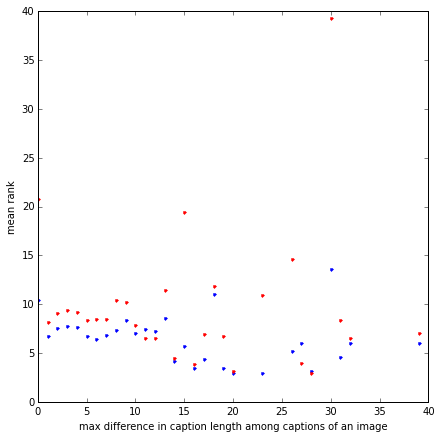

In [58]:
fig = plt.figure(figsize=(7,7))
#plt.title('Difference in mean rank between order- and symmetric embeddings for a given difference in caption length')
for key, result_dict in results.items():
    form = 'b.' if key == 'hierarchy' else 'r.'
    plt.plot(result_dict['diffs2mean'].keys(), result_dict['diffs2mean'].values(), form)
    plt.xlabel('max difference in caption length among captions of an image')
    plt.ylabel('mean rank')
plt.show()

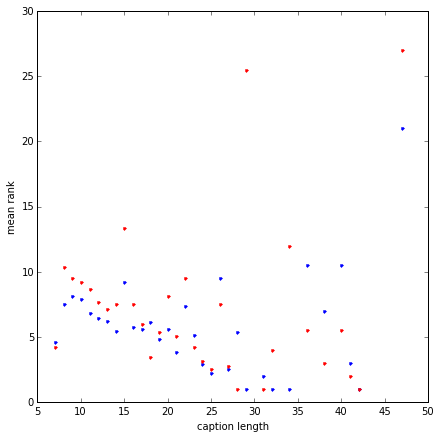

In [63]:
fig = plt.figure(figsize=(7,7))
#plt.title('Difference in mean rank between order- and symmetric embeddings for a given difference in caption length')

for key, result_dict in results.items():
    form = 'b.' if key == 'hierarchy' else 'r.'
    plt.plot(result_dict['len2mean'].keys(), result_dict['len2mean'].values(), form)
    plt.xlabel('caption length')
    plt.ylabel('mean rank')
plt.show()

In [23]:
import numpy
def c2c_rank(errors, cap1, cap2):
    """ computes rank of 2nd caption in the nearest neighbours list of the 1st """
    es = errors[cap1]
    inds = numpy.argsort(es)
    return numpy.where(inds == cap2%5000)[0][0] + 1

In [52]:
triplets = []
# find (image, caption, caption) triplets s.t. one of the captions is much longer than the other
for i in range(5000):
    for j in range(5):
        for k in range(5):
            c1 = 5*i + j
            c2 = 5*i + k
            cap1 = caps[c1].split()
            cap2 = caps[c2].split()
            if len(cap1) > len(cap2) + 15:
                triplets.append((i, c1, c2))

In [53]:
len(triplets)

107

In [55]:
ranks_hierarchy = []
ranks_cos = []
cranks_cos = []
cranks_h = []
for (i, cap1, cap2) in triplets[:100]:
    rank_cos_1 = results['cosine']['ranks'][cap1]
    rank_cos_2 = results['cosine']['ranks'][cap2]
    rank_h_1 = results['hierarchy']['ranks'][cap1]
    rank_h_2 = results['hierarchy']['ranks'][cap2]
    c2c_cos = c2c_rank(-results['cosine']['c2c_errs'], cap2, cap1)
    c2c_h = c2c_rank(results['hierarchy']['c2c_errs'], cap2, cap1)
    print('\t'.join(map(str, [i, cap1, cap2, rank_cos_1, rank_cos_2, rank_h_1, rank_h_2, c2c_cos, c2c_h])))
    ranks_cos.append(rank_cos_1)
    ranks_cos.append(rank_cos_2)
    ranks_hierarchy.append(rank_h_1)
    ranks_hierarchy.append(rank_h_2)
    cranks_cos.append(c2c_cos)
    cranks_h.append(c2c_h)
    
print(numpy.array(ranks_hierarchy).mean())
print(numpy.array(ranks_cos).mean())
print(numpy.array(cranks_cos).mean())
print(numpy.array(cranks_h).mean())

106	531	530	2.0	1.0	2.0	2.0	22	22
106	531	532	2.0	1.0	2.0	1.0	27	25
106	531	533	2.0	9.0	2.0	10.0	37	69
106	531	534	2.0	8.0	2.0	2.0	38	39
107	536	535	1.0	7.0	1.0	9.0	97	32
107	536	537	1.0	2.0	1.0	4.0	11	2
205	1028	1025	8.0	4.0	1.0	1.0	45	2
205	1028	1026	8.0	9.0	1.0	13.0	22	2
205	1028	1027	8.0	10.0	1.0	2.0	47	3
205	1028	1029	8.0	6.0	1.0	2.0	3	2
239	1196	1195	27.0	1.0	21.0	4.0	55	55
239	1196	1197	27.0	1.0	21.0	1.0	75	41
239	1196	1198	27.0	1.0	21.0	1.0	109	217
239	1196	1199	27.0	5.0	21.0	3.0	44	134
326	1631	1630	4.0	5.0	1.0	1.0	126	205
326	1631	1632	4.0	9.0	1.0	1.0	2	3
326	1631	1633	4.0	4.0	1.0	12.0	23	47
326	1631	1634	4.0	76.0	1.0	2.0	14	3
520	2602	2600	1.0	15.0	1.0	36.0	24	5
520	2602	2601	1.0	5.0	1.0	10.0	20	4
520	2602	2603	1.0	5.0	1.0	9.0	21	4
520	2602	2604	1.0	9.0	1.0	9.0	73	29
523	2618	2619	1.0	6.0	1.0	9.0	91	71
543	2718	2715	1.0	18.0	1.0	6.0	47	7
543	2718	2716	1.0	4.0	1.0	2.0	2	2
543	2718	2717	1.0	1.0	1.0	1.0	11	37
543	2718	2719	1.0	18.0	1.0	13.0	36	60
702	3514	3512	9.0	7.0	4.0	12.0	

In [71]:
ranks = numpy.array([rank(errs, i) for i in range(5000)])

In [72]:
ranks_cos = numpy.array([rank(errs_cos, i) for i in range(5000)])

In [73]:
ranks.mean()

6.3681999999999999

In [74]:
ranks_cos.mean()

7.6230000000000002

In [75]:
lens = numpy.array([len(cap.split()) for cap in caps])

In [66]:
caps[7201]

'a pigeon flying near white beams of a building'

In [81]:
diffs = []
for i in range(1000):
    for j in range(5):
        cap_j = 5*i + j
        max_diff = 0
        for k in range(5):
            cap_k = 5*i + k
            max_diff = max(max_diff, abs(len(caps[cap_k].split()) - len(caps[cap_j].split())))
        diffs.append(max_diff)

In [92]:
scipy.stats.spearmanr(ranks_cos, lens)

(-0.039184237677676474, 0.005586461686479389)

In [25]:
pairs = map(fromIndex, indices)

In [45]:
non_identity = [(i,j) for (i,j) in pairs if abs(i - j) > 4] # eliminate images that mighta come from the same caption

In [46]:
non_identity[:10]

[(716, 1300),
 (903, 1441),
 (2932, 2215),
 (4259, 426),
 (1300, 716),
 (1441, 903),
 (426, 4259),
 (4594, 3959),
 (3959, 4594),
 (2215, 2932)]

In [50]:
def no_shared_words(p):
    (i,j) = p
    w_i = caps[i].split()
    w_j = caps[j].split()
    
    return len(set(w_i) & set(w_j)) < (len(w_i) + len(w_j))/8

In [51]:
for (i,j) in filter(no_shared_words, non_identity)[:200]:
    print('%f | %s | %s ' % (captionErrs[j,i], caps[i], caps[j]))

0.126997 | an adult elephant and baby elephant walk together | old elephant be stand next to young elephant 
0.132185 | old elephant be stand next to young elephant | an adult elephant and baby elephant walk together 
0.139387 | three zebra look towards camera in their habitat | group of zebra stand next to each other 
0.140166 | person be on snowboard fly over mountain | snowboarder jump steep and snowy slope 
0.140740 | two elephant touch trunk with each other in grass | pair of elephant travel on grassy field 
0.145103 | pair of elephant line up next each other in an enclosure | two elephant at zoo with their trunk touch 
0.150840 | group of zebra walk away from tree | four zebra on dirt path look in different direction 
0.152551 | three motor cycle be sit in street outside coffee house a people walk by | row of motorcycle park at curb in outdoor area 
0.154018 | three zebra walk through grassland area together | bunch of zebra stand around in an open field 
0.155283 | line up of mo

In [29]:
norms = numpy.linalg.norm(S, axis=1)

In [25]:
lengths = numpy.array(map(lambda c: len(c.split()), caps))

In [27]:
lengths.min()

5

In [30]:
import scipy
scipy.stats.pearsonr(norms,lengths)

(-0.012179380524793164, 0.38922214785205911)